# DCGAN pentru Fashion-MNIST

## Introducere

Acest notebook implementează un **Deep Convolutional Generative Adversarial Network (DCGAN)** pentru generarea de imagini pe baza setului de date Fashion-MNIST.

### Obiective
- Implementarea unei arhitecturi DCGAN complete conform standardelor din literatură
- Antrenarea modelului pentru generarea de imagini de îmbrăcăminte
- Analiza stabilității antrenării și identificarea problemelor potențiale

### Bibliografie Principală
**Radford, A., Metz, L., & Chintala, S. (2015).** *Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.* arXiv preprint arXiv:1511.06434.

Această lucrare stabilește principiile fundamentale ale arhitecturii DCGAN:
- Eliminarea straturilor de pooling în favoarea convoluțiilor cu stride
- Utilizarea Batch Normalization în generator și discriminator
- Utilizarea ReLU în generator și LeakyReLU în discriminator
- Eliminarea straturilor fully-connected din arhitectură

In [1]:
# Importări necesare
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# Setare device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizat: {device}")

# Setare seed pentru reproductibilitate
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Matplotlib is building the font cache; this may take a moment.


Device utilizat: cpu


## 1. Încărcarea Datelor (Data Loading)

Fashion-MNIST este un set de date care conține 70,000 de imagini grayscale de 28x28 pixeli, reprezentând 10 categorii de îmbrăcăminte.

### Transformări Aplicate:
- **ToTensor()**: Convertește imagini în tensori PyTorch
- **Normalize(mean=0.5, std=0.5)**: Normalizează valorile pixelilor în intervalul [-1, 1]
  - Formula: `(pixel - 0.5) / 0.5` transformă [0, 1] → [-1, 1]
  - Acest interval este optim pentru funcția de activare Tanh din generator

**Notă**: Fashion-MNIST are deja dimensiunea 28x28, deci nu este necesară operația de Resize.

100.0%
100.0%
100.0%
100.0%


Număr de imagini de antrenare: 60000
Număr de batch-uri: 469
Dimensiune batch: 128


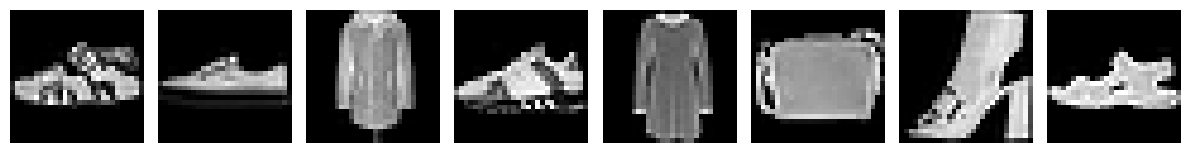

In [2]:
# Configurare parametri
BATCH_SIZE = 128
IMAGE_SIZE = 28
LATENT_DIM = 100  # Dimensiunea vectorului latent (z)

# Transformări pentru date
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # Normalizare la [-1, 1]
])

# Încărcare Fashion-MNIST
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2 if torch.cuda.is_available() else 0
)

# Verificare dimensiuni
print(f"Număr de imagini de antrenare: {len(train_dataset)}")
print(f"Număr de batch-uri: {len(train_loader)}")
print(f"Dimensiune batch: {BATCH_SIZE}")

# Vizualizare câteva imagini reale
def show_real_images(dataloader, num_images=8):
    """Afișează câteva imagini reale din setul de date"""
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    # Denormalizare pentru vizualizare: [-1, 1] → [0, 1]
    images = (images + 1) / 2
    images = images.clamp(0, 1)
    
    fig, axes = plt.subplots(1, num_images, figsize=(12, 2))
    for i in range(num_images):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_real_images(train_loader)

## 2. Arhitectura Generatorului

Generatorul transformă un vector latent aleator (z) într-o imagine de 28x28 pixeli.

### Principii Arhitecturale (Radford et al., 2015):
1. **Convolution Transpose (Deconvolution)**: Folosit pentru upsampling progresiv
2. **Batch Normalization**: Aplicat după fiecare strat convoluțional (exceptând stratul de output)
3. **ReLU**: Funcție de activare pentru straturile intermediare
4. **Tanh**: Funcție de activare finală pentru a produce valori în intervalul [-1, 1]

### Structură:
- Input: Vector latent de dimensiune `LATENT_DIM` (100)
- Output: Imagine de 28x28x1 (grayscale)

**Notă**: Nu folosim straturi fully-connected, conform principiilor DCGAN.

In [4]:
class Generator(nn.Module):
    """
    Generator DCGAN pentru Fashion-MNIST
    
    Transformă un vector latent z într-o imagine de 28x28 pixeli.
    """
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        # Progresie: 100 → 7x7x256 → 14x14x128 → 28x28x64 → 28x28x1
        self.main = nn.Sequential(
            # Bloc 1: 100 → 7x7x256
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # Bloc 2: 7x7x256 → 14x14x128
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # Bloc 3: 14x14x128 → 28x28x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # Bloc 4: 28x28x64 → 28x28x1 (output)
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()  # Output în intervalul [-1, 1]
        )
    
    def forward(self, z):
        """
        Forward pass: transformă vectorul latent în imagine
        
        Args:
            z: Tensor de forma (batch_size, latent_dim, 1, 1)
        
        Returns:
            Tensor de forma (batch_size, 1, 28, 28)
        """
        # Reshape z pentru convoluție: (batch_size, latent_dim) → (batch_size, latent_dim, 1, 1)
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.main(z)

# Testare generator
generator = Generator(latent_dim=LATENT_DIM).to(device)
print("Generator:")
print(generator)

# Test forward pass
test_z = torch.randn(4, LATENT_DIM).to(device)
test_output = generator(test_z)
print(f"\nInput shape: {test_z.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output range: [{test_output.min().item():.3f}, {test_output.max().item():.3f}]")

Generator:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

Input shape: torch.Size([4, 100])
Output shape: torch.Size([4, 1, 28, 28])
Output range: [-1.000, 1.000]


In [5]:
class Discriminator(nn.Module):
    """
    Discriminator DCGAN pentru Fashion-MNIST
    
    Clasifică dacă o imagine este reală sau generată.
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Progresie: 28x28x1 → 14x14x64 → 7x7x128 → 1x1x256 → 1 (scalar)
        self.main = nn.Sequential(
            # Bloc 1: 28x28x1 → 14x14x64
            # Fără BatchNorm în primul strat (conform DCGAN)
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Bloc 2: 14x14x64 → 7x7x128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Bloc 3: 7x7x128 → 1x1x256
            nn.Conv2d(128, 256, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Output: 1x1x256 → 1 (scalar)
            nn.Conv2d(256, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # Probabilitate între [0, 1]
        )
    
    def forward(self, img):
        """
        Forward pass: clasifică imaginea ca reală sau falsă
        
        Args:
            img: Tensor de forma (batch_size, 1, 28, 28)
        
        Returns:
            Tensor de forma (batch_size, 1) - probabilitatea că imaginea este reală
        """
        return self.main(img).view(img.size(0), -1)

# Testare discriminator
discriminator = Discriminator().to(device)
print("Discriminator:")
print(discriminator)

# Test forward pass
test_img = torch.randn(4, 1, 28, 28).to(device)
test_output = discriminator(test_img)
print(f"\nInput shape: {test_img.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output range: [{test_output.min().item():.3f}, {test_output.max().item():.3f}]")

Discriminator:
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

Input shape: torch.Size([4, 1, 28, 28])
Output shape: torch.Size([4, 1])
Output range: [0.284, 0.653]


## 4. Configurare Antrenare

### Funcția de Pierdere: Binary Cross Entropy (BCE)

**De ce folosim BCE Loss?**

1. **Problema de clasificare binară**: Discriminatorul trebuie să distingă între imagini reale (label=1) și imagini false (label=0). Aceasta este o problemă de clasificare binară.

2. **Formulă matematică**: 
   - Pentru imagini reale: `loss = -log(D(x))` → minimizăm când D(x) → 1
   - Pentru imagini false: `loss = -log(1 - D(G(z)))` → minimizăm când D(G(z)) → 0

3. **Stabilitate**: BCE oferă gradienti bine comportați pentru antrenarea ambelor rețele.

4. **Interpretare probabilistică**: Output-ul discriminatorului (Sigmoid) reprezintă o probabilitate, iar BCE este loss-ul standard pentru probabilități.

### Optimizatori
- **Adam**: Optimizator adaptiv recomandat pentru GAN-uri
- **Learning Rate**: 0.0002 (standard pentru DCGAN)
- **Beta1**: 0.5 (recomandat de Radford et al. pentru stabilitate)

In [6]:
# Inițializare modele
generator = Generator(latent_dim=LATENT_DIM).to(device)
discriminator = Discriminator().to(device)

# Funcție de pierdere: Binary Cross Entropy
criterion = nn.BCELoss()

# Etichete pentru antrenare
real_label = 1.0
fake_label = 0.0

# Optimizatori
# Learning rate și beta1 conform recomandărilor din Radford et al. (2015)
lr = 0.0002
beta1 = 0.5

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

print("Configurare completă!")
print(f"Learning rate: {lr}")
print(f"Beta1: {beta1}")
print(f"Funcție pierdere: {criterion}")

Configurare completă!
Learning rate: 0.0002
Beta1: 0.5
Funcție pierdere: BCELoss()


## 5. Funcții de Vizualizare

Funcții pentru salvarea și afișarea imaginilor generate în timpul antrenării.

In [8]:
def save_generated_images(generator, epoch, latent_dim=100, num_images=64, save_dir='./generated_images'):
    """
    Generează și salvează o grilă de imagini generate
    
    Args:
        generator: Modelul generator
        epoch: Numărul epocii curente
        latent_dim: Dimensiunea vectorului latent
        num_images: Numărul de imagini de generat (trebuie să fie pătrat perfect pentru grilă)
        save_dir: Directorul unde se salvează imaginile
    """
    # Creează directorul dacă nu există
    os.makedirs(save_dir, exist_ok=True)
    
    # Setează generatorul în modul de evaluare
    generator.eval()
    
    # Generează vectori latenți aleatori
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        fake_images = generator(z)
    
    # Denormalizare: [-1, 1] → [0, 1]
    fake_images = (fake_images + 1) / 2
    fake_images = fake_images.clamp(0, 1)
    
    # Calculează dimensiunea grilei (ex: 64 imagini → grilă 8x8)
    grid_size = int(np.sqrt(num_images))
    
    # Creează grila de imagini
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    fig.suptitle(f'Imagini generate - Epoca {epoch}', fontsize=16)
    
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            axes[i, j].imshow(fake_images[idx].cpu().squeeze(), cmap='gray')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    
    # Salvează imaginea
    save_path = os.path.join(save_dir, f'epoch_{epoch:03d}.png')
    plt.savefig(save_path)
    plt.show()
    
    # Revine la modul de antrenare
    generator.train()
    
    return save_path

## 6. Monitorizare Gradienti pentru Analiza Instabilității

Una dintre problemele majore în antrenarea GAN-urilor este instabilitatea, care poate manifesta prin:

1. **Vanishing Gradients**: Gradientii devin prea mici, antrenarea se oprește
2. **Mode Collapse**: Generatorul produce doar câteva tipuri de imagini, ignorând diversitatea
3. **Non-convergență**: Pierderile oscilează fără să convergă

Vom monitoriza:
- Gradientii medii pentru fiecare strat
- Variația gradientilor (pentru a detecta vanishing gradients)
- Diversitatea imaginilor generate (pentru a detecta mode collapse)

In [9]:
def compute_gradient_norms(model):
    """
    Calculează norma gradientilor pentru fiecare parametru al modelului
    
    Args:
        model: Modelul (Generator sau Discriminator)
    
    Returns:
        Dict cu statistici despre gradienti
    """
    total_norm = 0
    param_norms = []
    
    for name, param in model.named_parameters():
        if param.grad is not None:
            param_norm = param.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
            param_norms.append((name, param_norm.item()))
        else:
            param_norms.append((name, 0.0))
    
    total_norm = total_norm ** (1. / 2)
    
    return {
        'total_norm': total_norm,
        'param_norms': param_norms,
        'mean_norm': np.mean([p[1] for p in param_norms if p[1] > 0]),
        'max_norm': max([p[1] for p in param_norms]),
        'min_norm': min([p[1] for p in param_norms if p[1] > 0]) if any(p[1] > 0 for p in param_norms) else 0
    }

def check_mode_collapse(generated_images, threshold=0.1):
    """
    Verifică dacă există mode collapse prin analiza variabilității pixelilor
    
    Args:
        generated_images: Tensor de imagini generate (batch_size, 1, 28, 28)
        threshold: Prag pentru a detecta mode collapse
    
    Returns:
        Dict cu statistici despre diversitate
    """
    # Calculează deviația standard pentru fiecare poziție de pixel
    std_per_pixel = generated_images.std(dim=0)
    mean_std = std_per_pixel.mean().item()
    
    # Dacă deviația standard este foarte mică, există posibilitatea de mode collapse
    is_collapsed = mean_std < threshold
    
    return {
        'mean_std': mean_std,
        'is_collapsed': is_collapsed,
        'threshold': threshold
    }

# Listă pentru stocarea statisticilor
gradient_history = {
    'G': {'norms': [], 'epochs': []},
    'D': {'norms': [], 'epochs': []}
}
mode_collapse_history = []

## 7. Bucla de Antrenare (Training Loop)

Pipeline-ul de antrenare urmează următoarea secvență:

1. **Antrenare Discriminator**:
   - Forward pass pe imagini reale → loss_real
   - Generare imagini false → forward pass → loss_fake
   - Loss total: loss_real + loss_fake
   - Backward pass și update

2. **Antrenare Generator**:
   - Generare imagini false
   - Forward pass prin discriminator (cu etichete "reale")
   - Loss: cât de bine am păcălit discriminatorul
   - Backward pass și update

**Notă**: Antrenăm discriminatorul de 2 ori mai des decât generatorul pentru stabilitate (opțional, dar recomandat).

Început antrenare...
Număr epoci: 50
Batch size: 128
Lungime dataset: 60000
--------------------------------------------------
Epoch [0/50] Batch [0/469] Loss_D: 1.4328 (Real: 0.6700, Fake: 0.7628) Loss_G: 0.6712
Epoch [0/50] Batch [100/469] Loss_D: 1.3374 (Real: 0.6647, Fake: 0.6726) Loss_G: 0.7445
Epoch [0/50] Batch [200/469] Loss_D: 1.2294 (Real: 0.6038, Fake: 0.6255) Loss_G: 0.7967
Epoch [0/50] Batch [300/469] Loss_D: 1.1207 (Real: 0.5600, Fake: 0.5607) Loss_G: 0.8932
Epoch [0/50] Batch [400/469] Loss_D: 1.0693 (Real: 0.5576, Fake: 0.5117) Loss_G: 1.0120
Epoch [0/50] - Loss_G: 0.8594, Loss_D: 1.2093


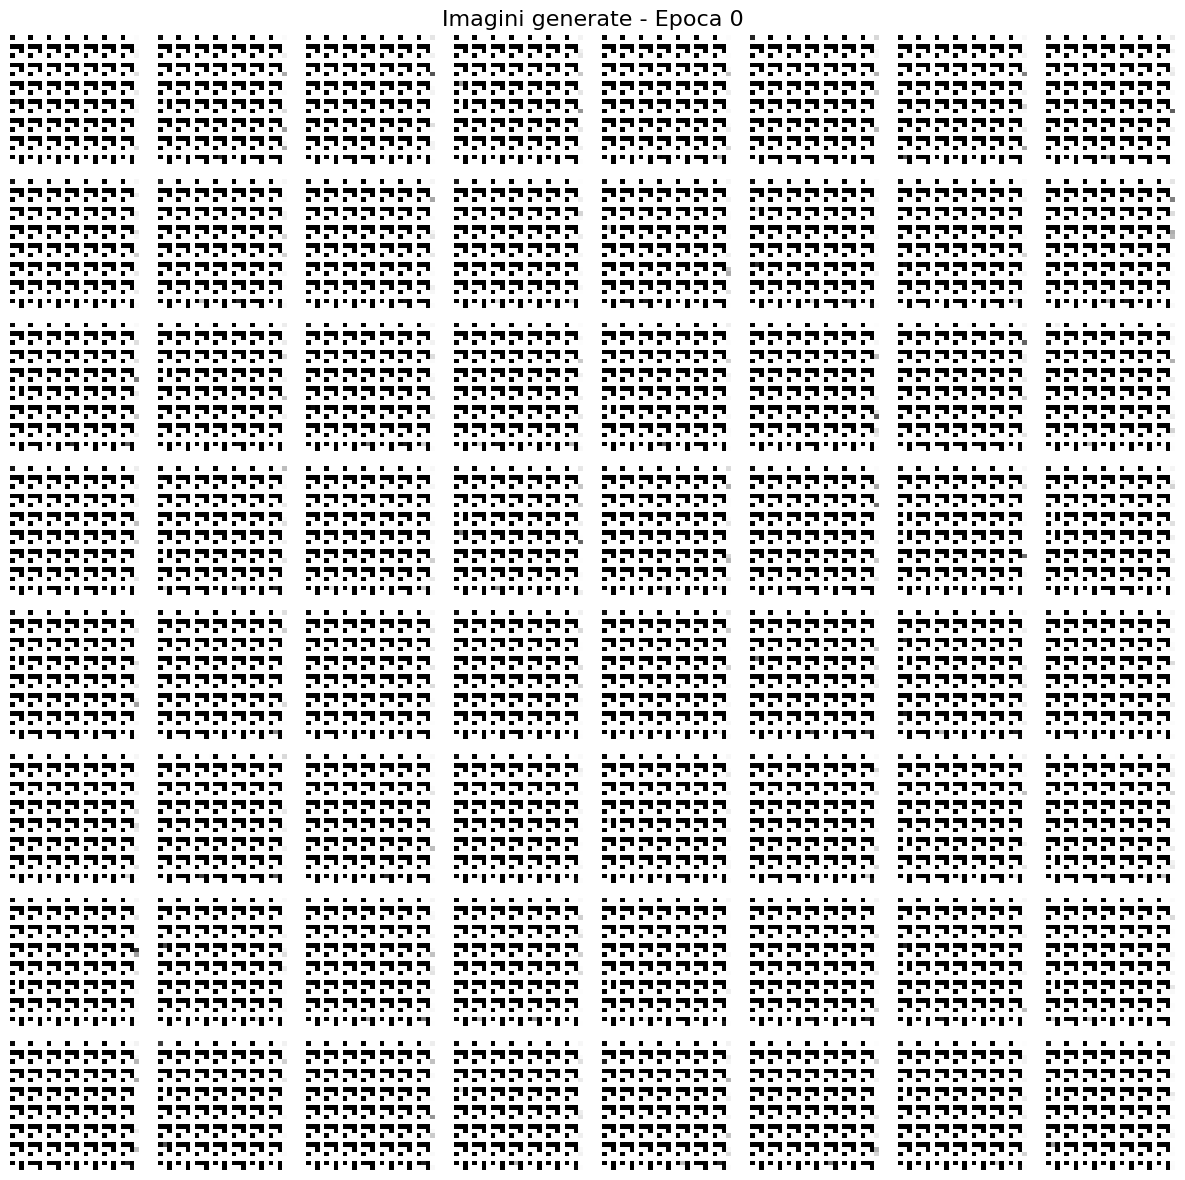

Epoch [1/50] Batch [0/469] Loss_D: 0.9945 (Real: 0.4985, Fake: 0.4960) Loss_G: 1.0929
Epoch [1/50] Batch [100/469] Loss_D: 0.8876 (Real: 0.4512, Fake: 0.4364) Loss_G: 1.2151
Epoch [1/50] Batch [200/469] Loss_D: 0.8686 (Real: 0.4670, Fake: 0.4016) Loss_G: 1.3602
Epoch [1/50] Batch [300/469] Loss_D: 0.7298 (Real: 0.3341, Fake: 0.3957) Loss_G: 1.5334
Epoch [1/50] Batch [400/469] Loss_D: 0.7331 (Real: 0.3552, Fake: 0.3779) Loss_G: 1.6088
Epoch [1/50] - Loss_G: 1.4121, Loss_D: 0.8169
Epoch [2/50] Batch [0/469] Loss_D: 0.6090 (Real: 0.2721, Fake: 0.3370) Loss_G: 1.7263
Epoch [2/50] Batch [100/469] Loss_D: 0.5786 (Real: 0.2497, Fake: 0.3289) Loss_G: 1.8768
Epoch [2/50] Batch [200/469] Loss_D: 0.5779 (Real: 0.3215, Fake: 0.2563) Loss_G: 2.0867
Epoch [2/50] Batch [300/469] Loss_D: 0.4872 (Real: 0.2288, Fake: 0.2584) Loss_G: 2.1414
Epoch [2/50] Batch [400/469] Loss_D: 0.4667 (Real: 0.2520, Fake: 0.2147) Loss_G: 2.3195
Epoch [2/50] - Loss_G: 2.0790, Loss_D: 0.5451
Epoch [3/50] Batch [0/469] Loss_

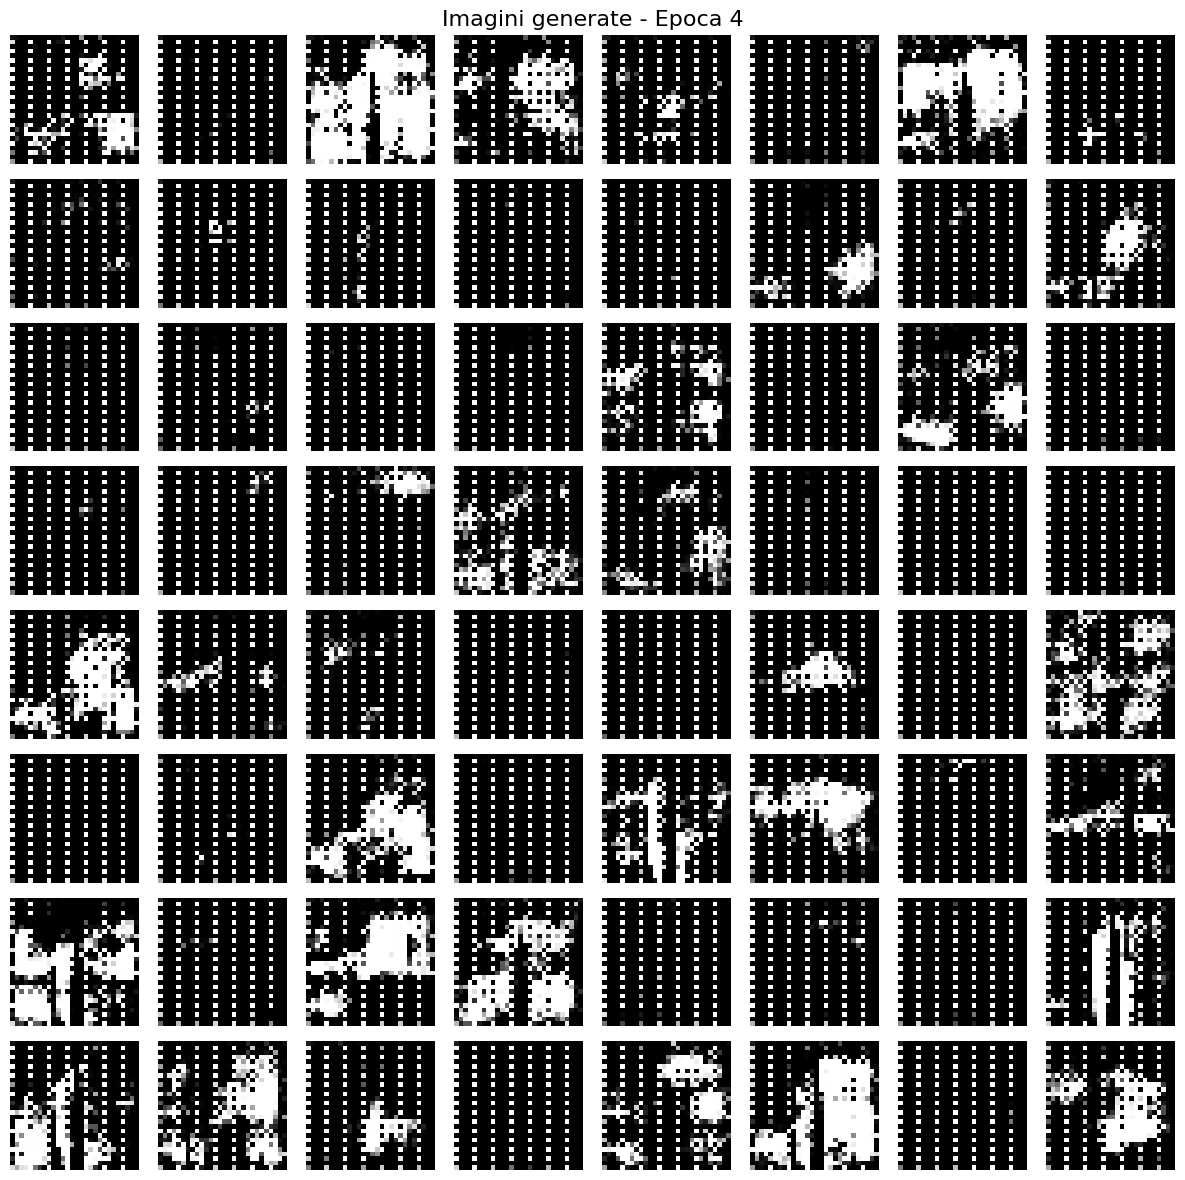

Epoch [5/50] Batch [0/469] Loss_D: 0.3037 (Real: 0.1301, Fake: 0.1736) Loss_G: 3.0477
Epoch [5/50] Batch [100/469] Loss_D: 0.8189 (Real: 0.3870, Fake: 0.4320) Loss_G: 1.9206
Epoch [5/50] Batch [200/469] Loss_D: 0.9082 (Real: 0.3641, Fake: 0.5442) Loss_G: 1.6371
Epoch [5/50] Batch [300/469] Loss_D: 0.8387 (Real: 0.4449, Fake: 0.3938) Loss_G: 1.5291
Epoch [5/50] Batch [400/469] Loss_D: 1.1424 (Real: 0.5619, Fake: 0.5805) Loss_G: 1.1100
Epoch [5/50] - Loss_G: 1.6688, Loss_D: 0.9353
Epoch [6/50] Batch [0/469] Loss_D: 1.2043 (Real: 0.5916, Fake: 0.6127) Loss_G: 1.0869
Epoch [6/50] Batch [100/469] Loss_D: 1.2303 (Real: 0.5371, Fake: 0.6932) Loss_G: 1.2618
Epoch [6/50] Batch [200/469] Loss_D: 1.0484 (Real: 0.5209, Fake: 0.5276) Loss_G: 1.2389
Epoch [6/50] Batch [300/469] Loss_D: 1.3625 (Real: 0.6094, Fake: 0.7531) Loss_G: 1.2934
Epoch [6/50] Batch [400/469] Loss_D: 1.2187 (Real: 0.5870, Fake: 0.6317) Loss_G: 1.2783
Epoch [6/50] - Loss_G: 1.3103, Loss_D: 1.1306
Epoch [7/50] Batch [0/469] Loss_

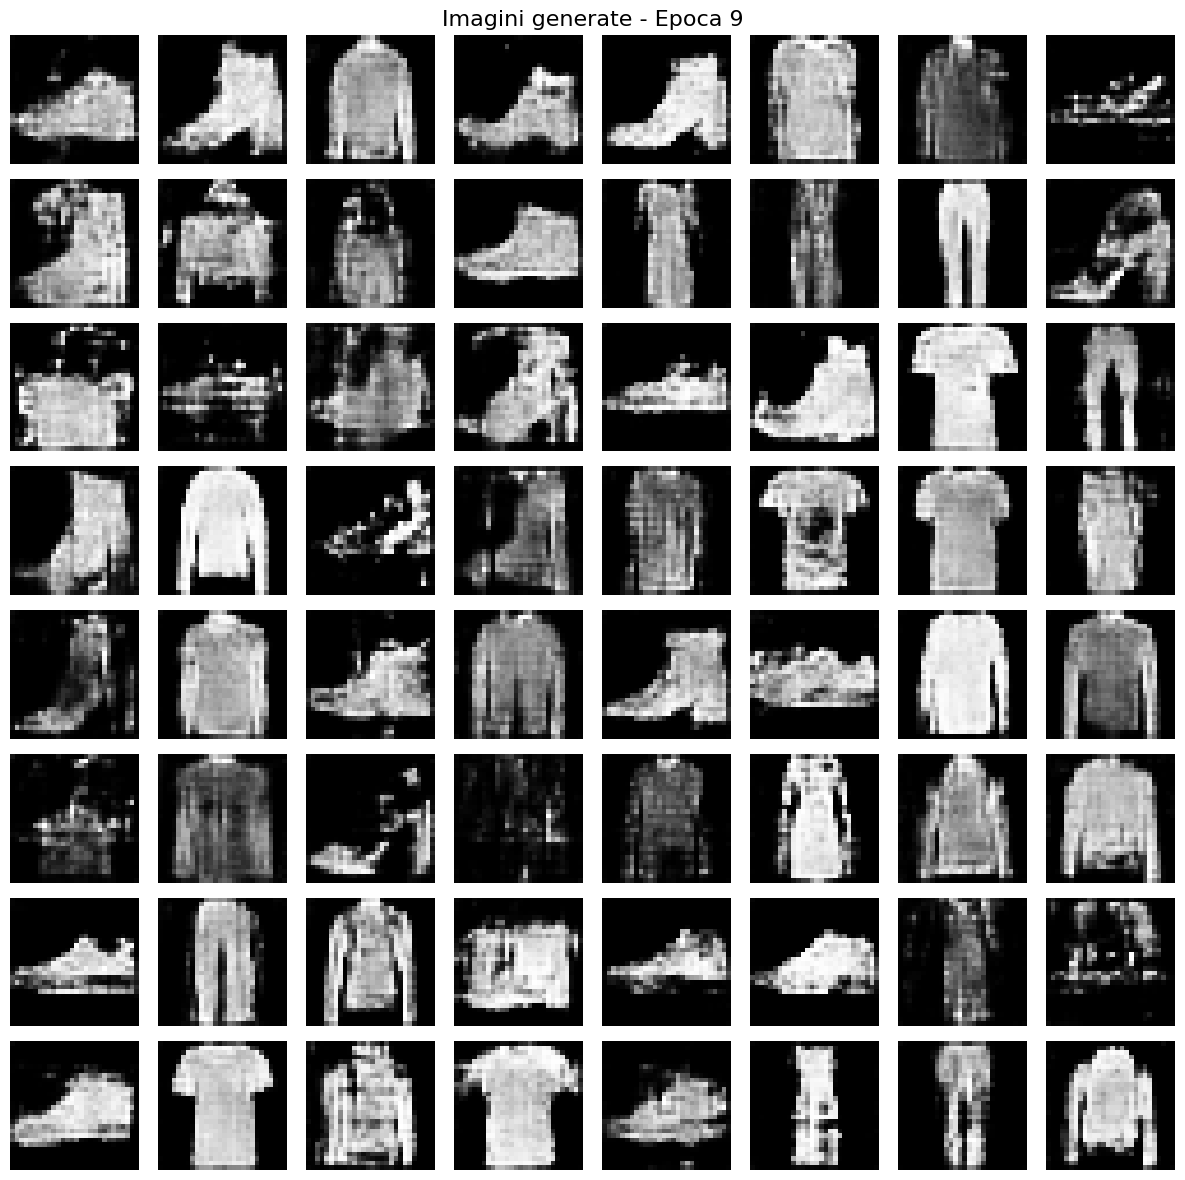

Epoch [10/50] Batch [0/469] Loss_D: 1.0779 (Real: 0.4699, Fake: 0.6079) Loss_G: 1.1066
Epoch [10/50] Batch [100/469] Loss_D: 1.1160 (Real: 0.5740, Fake: 0.5420) Loss_G: 1.0740
Epoch [10/50] Batch [200/469] Loss_D: 1.1468 (Real: 0.5712, Fake: 0.5756) Loss_G: 1.0455
Epoch [10/50] Batch [300/469] Loss_D: 1.1052 (Real: 0.5845, Fake: 0.5206) Loss_G: 1.1427
Epoch [10/50] Batch [400/469] Loss_D: 1.1167 (Real: 0.4766, Fake: 0.6401) Loss_G: 1.1526
Epoch [10/50] - Loss_G: 1.1823, Loss_D: 1.1345
Epoch [11/50] Batch [0/469] Loss_D: 1.0681 (Real: 0.5231, Fake: 0.5450) Loss_G: 1.1761
Epoch [11/50] Batch [100/469] Loss_D: 1.1988 (Real: 0.5861, Fake: 0.6127) Loss_G: 1.3162
Epoch [11/50] Batch [200/469] Loss_D: 1.0849 (Real: 0.5587, Fake: 0.5262) Loss_G: 1.0934
Epoch [11/50] Batch [300/469] Loss_D: 1.1831 (Real: 0.5696, Fake: 0.6135) Loss_G: 1.3044
Epoch [11/50] Batch [400/469] Loss_D: 1.1457 (Real: 0.6258, Fake: 0.5199) Loss_G: 1.1712
Epoch [11/50] - Loss_G: 1.1610, Loss_D: 1.1366
Epoch [12/50] Batch 

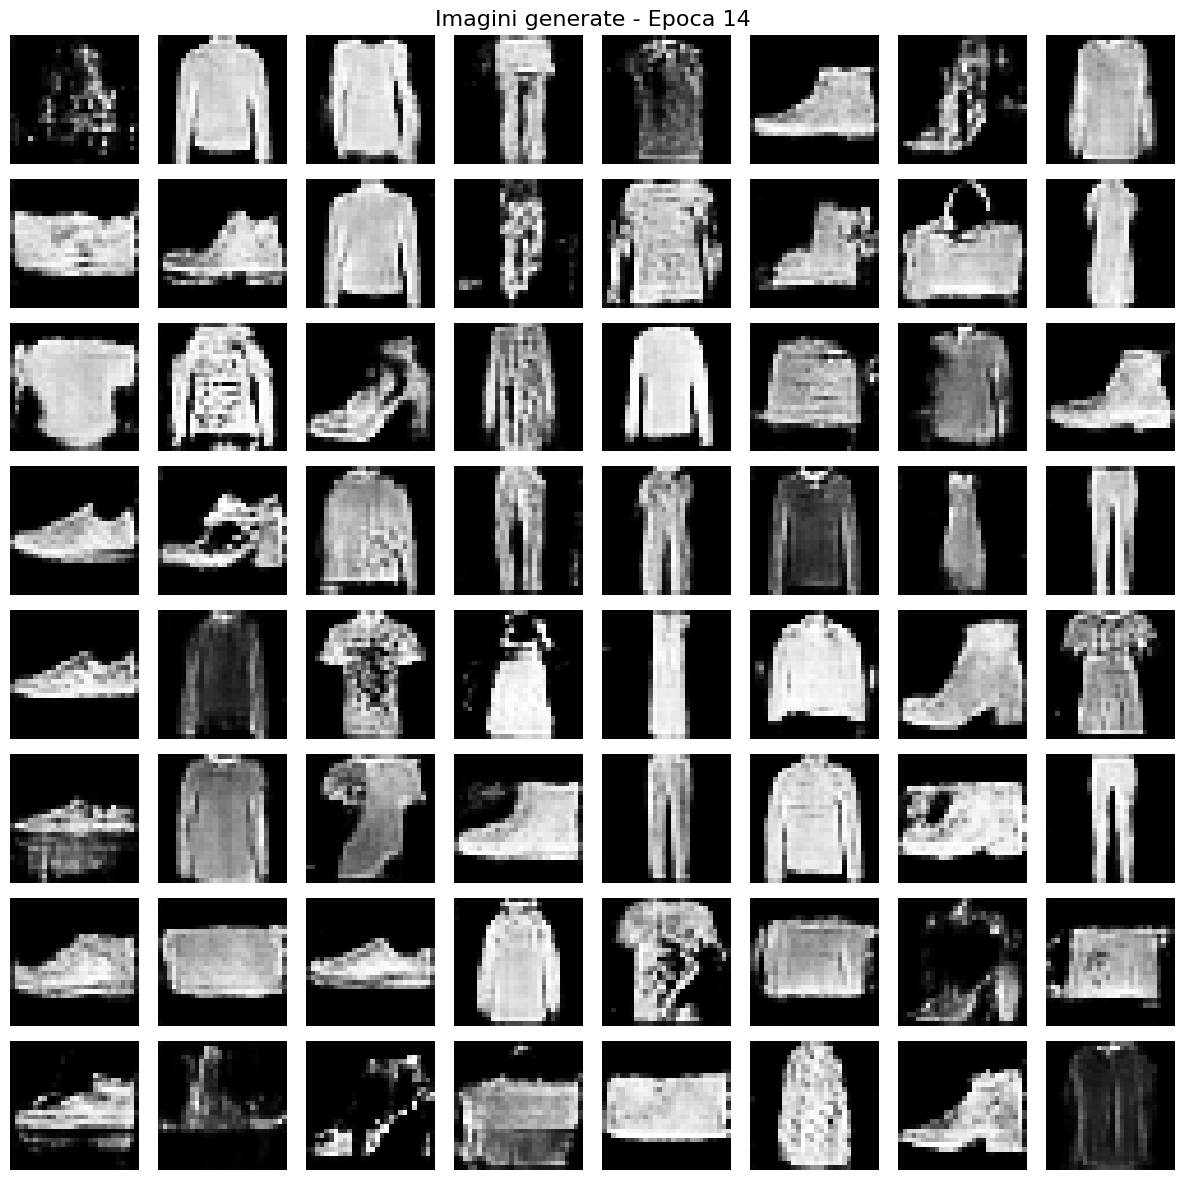

Epoch [15/50] Batch [0/469] Loss_D: 1.0739 (Real: 0.5128, Fake: 0.5611) Loss_G: 1.2801
Epoch [15/50] Batch [100/469] Loss_D: 1.2493 (Real: 0.6853, Fake: 0.5640) Loss_G: 1.0876
Epoch [15/50] Batch [200/469] Loss_D: 1.1901 (Real: 0.5981, Fake: 0.5920) Loss_G: 1.1985
Epoch [15/50] Batch [300/469] Loss_D: 1.1166 (Real: 0.4950, Fake: 0.6216) Loss_G: 1.0497
Epoch [15/50] Batch [400/469] Loss_D: 1.2613 (Real: 0.5989, Fake: 0.6624) Loss_G: 1.0429
Epoch [15/50] - Loss_G: 1.1126, Loss_D: 1.1505
Epoch [16/50] Batch [0/469] Loss_D: 1.1235 (Real: 0.5665, Fake: 0.5569) Loss_G: 0.9919
Epoch [16/50] Batch [100/469] Loss_D: 1.1701 (Real: 0.5591, Fake: 0.6110) Loss_G: 1.1361
Epoch [16/50] Batch [200/469] Loss_D: 1.2178 (Real: 0.6328, Fake: 0.5850) Loss_G: 1.0790
Epoch [16/50] Batch [300/469] Loss_D: 1.1422 (Real: 0.5331, Fake: 0.6091) Loss_G: 1.1613
Epoch [16/50] Batch [400/469] Loss_D: 1.0929 (Real: 0.5219, Fake: 0.5709) Loss_G: 1.0636
Epoch [16/50] - Loss_G: 1.1128, Loss_D: 1.1442
Epoch [17/50] Batch 

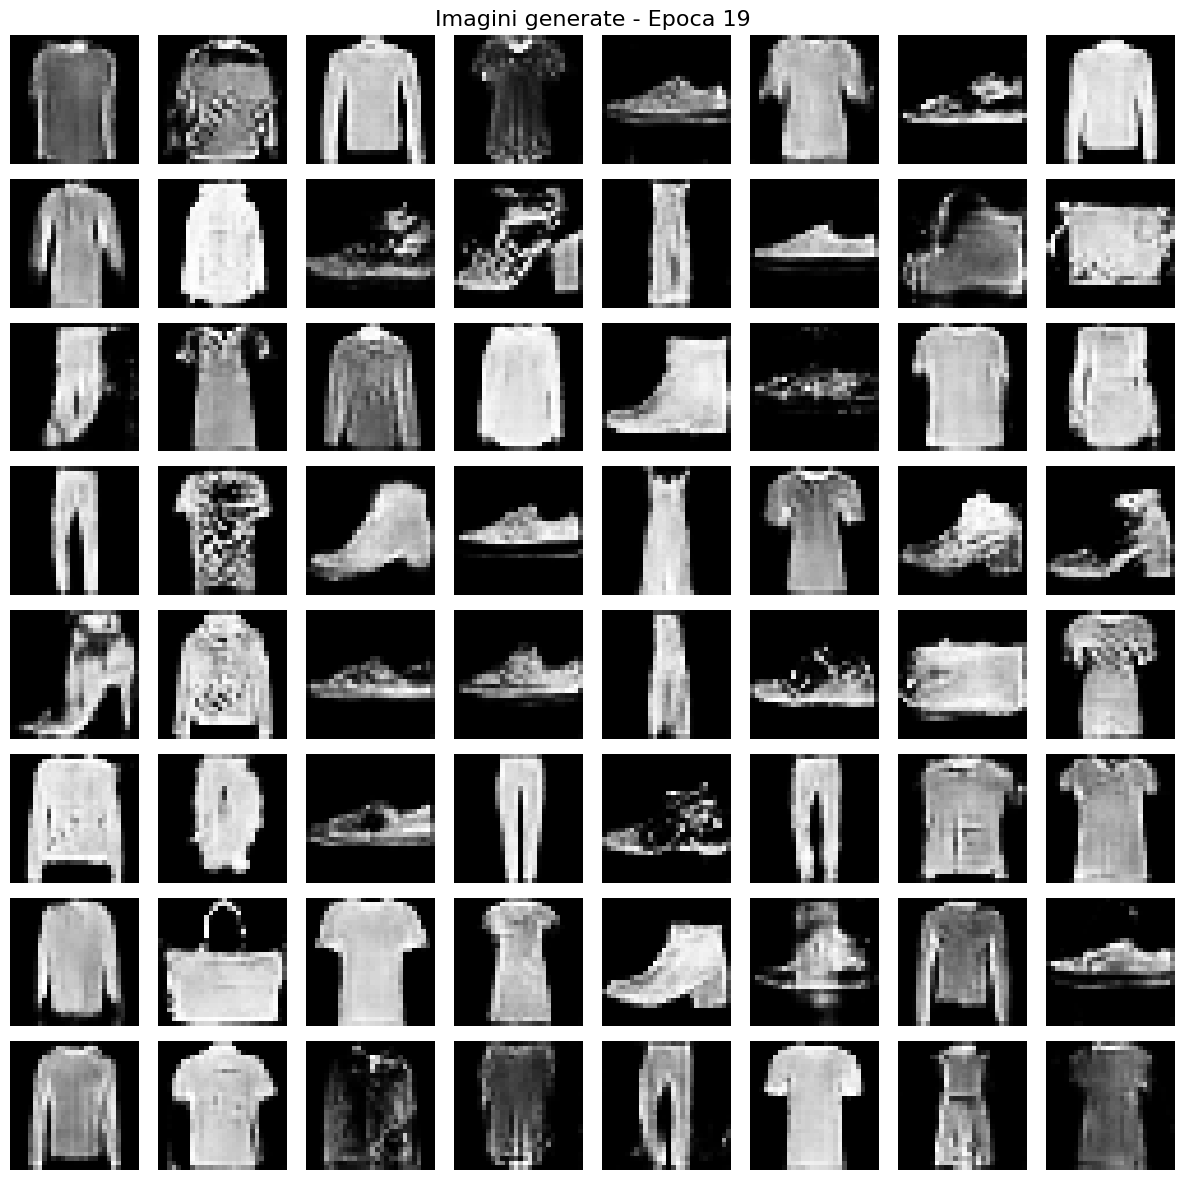

Epoch [20/50] Batch [0/469] Loss_D: 1.2350 (Real: 0.5815, Fake: 0.6535) Loss_G: 1.1701
Epoch [20/50] Batch [100/469] Loss_D: 1.2787 (Real: 0.6465, Fake: 0.6322) Loss_G: 0.9744
Epoch [20/50] Batch [200/469] Loss_D: 1.1398 (Real: 0.5338, Fake: 0.6060) Loss_G: 1.2164
Epoch [20/50] Batch [300/469] Loss_D: 1.1422 (Real: 0.5913, Fake: 0.5509) Loss_G: 1.0888
Epoch [20/50] Batch [400/469] Loss_D: 1.2831 (Real: 0.6119, Fake: 0.6712) Loss_G: 1.0773
Epoch [20/50] - Loss_G: 1.0831, Loss_D: 1.1675
Epoch [21/50] Batch [0/469] Loss_D: 1.2266 (Real: 0.6324, Fake: 0.5942) Loss_G: 0.9788
Epoch [21/50] Batch [100/469] Loss_D: 1.1136 (Real: 0.6043, Fake: 0.5093) Loss_G: 1.3320
Epoch [21/50] Batch [200/469] Loss_D: 1.1951 (Real: 0.5862, Fake: 0.6089) Loss_G: 1.0684
Epoch [21/50] Batch [300/469] Loss_D: 1.1089 (Real: 0.5708, Fake: 0.5381) Loss_G: 1.0758
Epoch [21/50] Batch [400/469] Loss_D: 1.1988 (Real: 0.6501, Fake: 0.5487) Loss_G: 1.0511
Epoch [21/50] - Loss_G: 1.0795, Loss_D: 1.1742
Epoch [22/50] Batch 

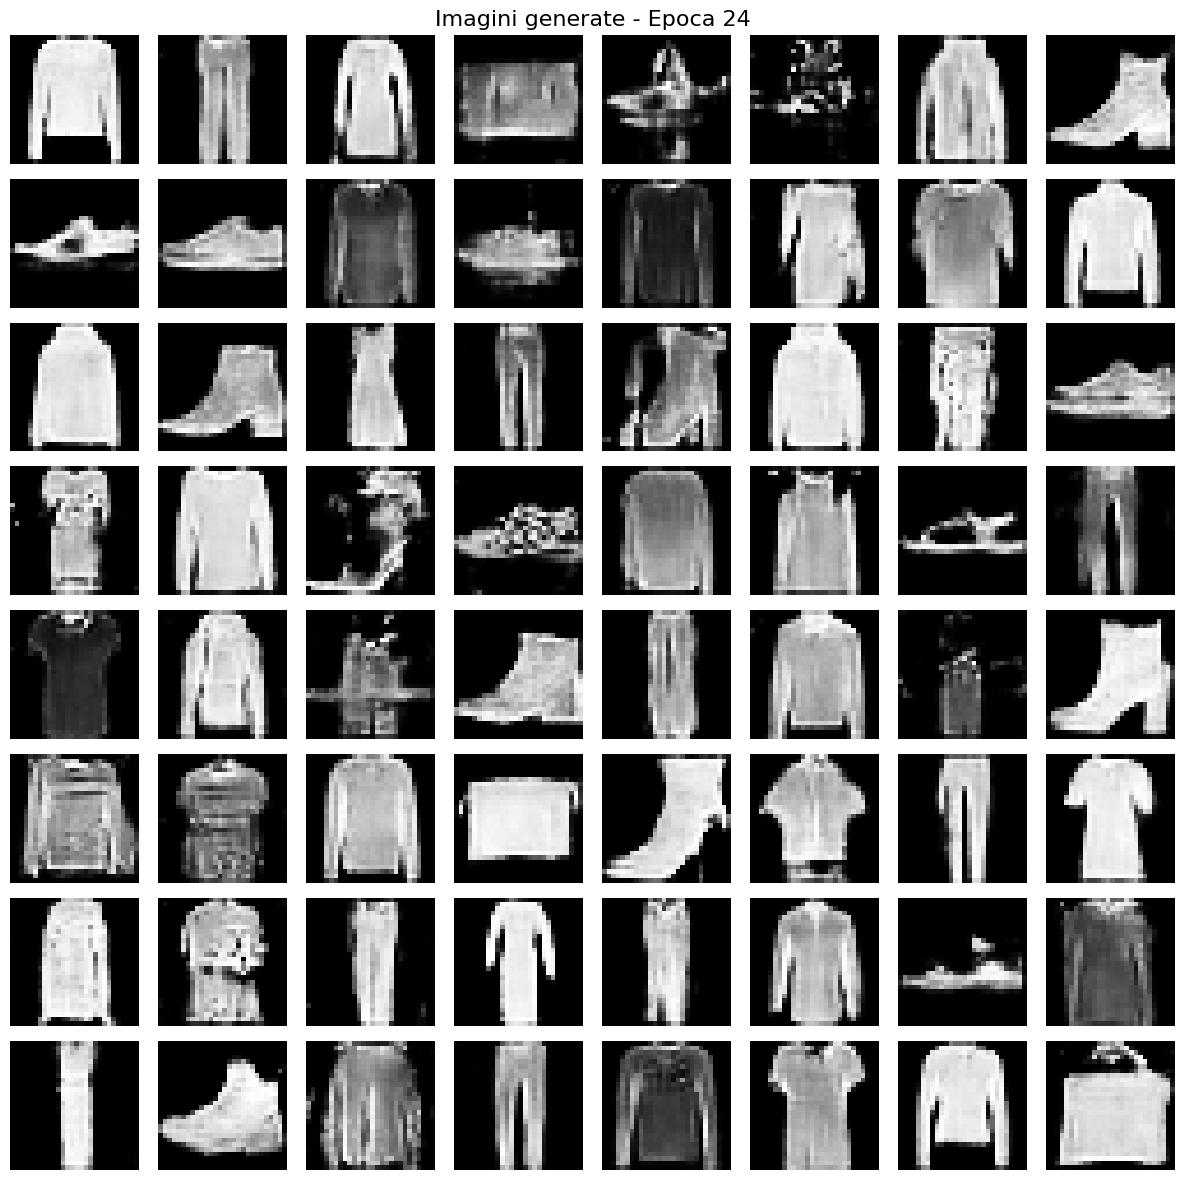

Epoch [25/50] Batch [0/469] Loss_D: 1.0904 (Real: 0.5748, Fake: 0.5156) Loss_G: 1.0659
Epoch [25/50] Batch [100/469] Loss_D: 1.1617 (Real: 0.5868, Fake: 0.5748) Loss_G: 1.0168
Epoch [25/50] Batch [200/469] Loss_D: 1.1512 (Real: 0.5761, Fake: 0.5751) Loss_G: 1.0666
Epoch [25/50] Batch [300/469] Loss_D: 1.2234 (Real: 0.6567, Fake: 0.5668) Loss_G: 1.0368
Epoch [25/50] Batch [400/469] Loss_D: 1.1528 (Real: 0.5456, Fake: 0.6072) Loss_G: 1.0536
Epoch [25/50] - Loss_G: 1.0512, Loss_D: 1.1858
Epoch [26/50] Batch [0/469] Loss_D: 1.2276 (Real: 0.5830, Fake: 0.6446) Loss_G: 1.1037
Epoch [26/50] Batch [100/469] Loss_D: 1.2533 (Real: 0.6159, Fake: 0.6374) Loss_G: 0.9777
Epoch [26/50] Batch [200/469] Loss_D: 1.1724 (Real: 0.5652, Fake: 0.6072) Loss_G: 1.0620
Epoch [26/50] Batch [300/469] Loss_D: 1.2716 (Real: 0.6523, Fake: 0.6193) Loss_G: 0.8638
Epoch [26/50] Batch [400/469] Loss_D: 1.1721 (Real: 0.6009, Fake: 0.5712) Loss_G: 0.9854
Epoch [26/50] - Loss_G: 1.0510, Loss_D: 1.1869
Epoch [27/50] Batch 

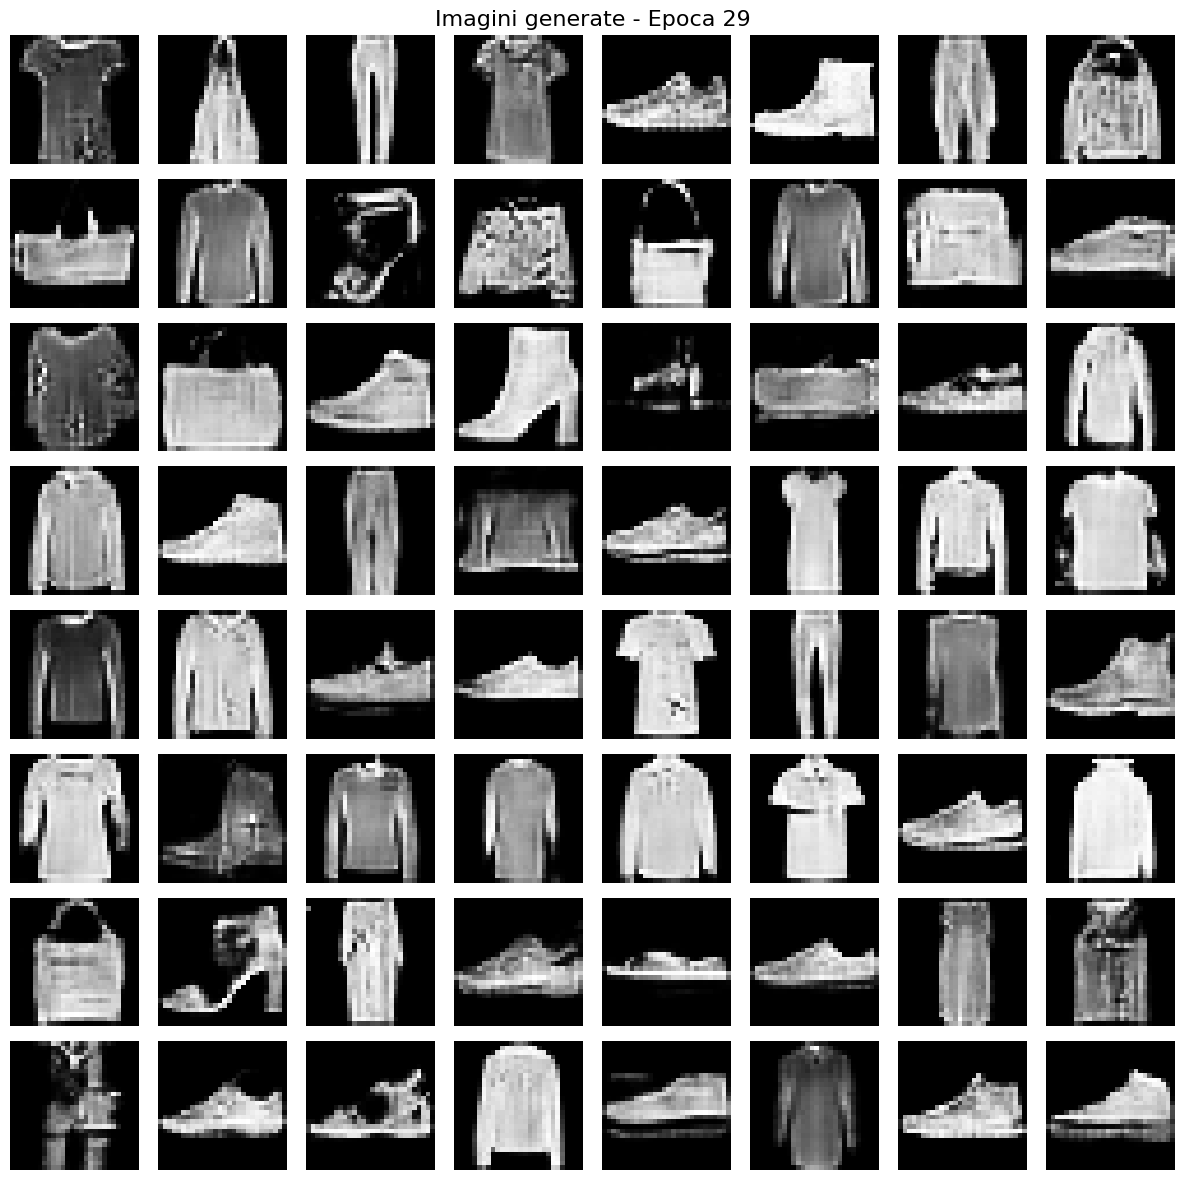

Epoch [30/50] Batch [0/469] Loss_D: 1.2097 (Real: 0.6021, Fake: 0.6076) Loss_G: 1.0010
Epoch [30/50] Batch [100/469] Loss_D: 1.1479 (Real: 0.5734, Fake: 0.5745) Loss_G: 0.9907
Epoch [30/50] Batch [200/469] Loss_D: 1.1479 (Real: 0.5845, Fake: 0.5635) Loss_G: 1.0477
Epoch [30/50] Batch [300/469] Loss_D: 1.1686 (Real: 0.6154, Fake: 0.5532) Loss_G: 1.0020
Epoch [30/50] Batch [400/469] Loss_D: 1.3775 (Real: 0.7004, Fake: 0.6771) Loss_G: 1.1151
Epoch [30/50] - Loss_G: 1.0357, Loss_D: 1.1929
Epoch [31/50] Batch [0/469] Loss_D: 1.2441 (Real: 0.6932, Fake: 0.5509) Loss_G: 0.9890
Epoch [31/50] Batch [100/469] Loss_D: 1.1965 (Real: 0.5917, Fake: 0.6048) Loss_G: 1.0654
Epoch [31/50] Batch [200/469] Loss_D: 1.1794 (Real: 0.6440, Fake: 0.5354) Loss_G: 1.1218
Epoch [31/50] Batch [300/469] Loss_D: 1.2388 (Real: 0.7016, Fake: 0.5372) Loss_G: 0.9631
Epoch [31/50] Batch [400/469] Loss_D: 1.2327 (Real: 0.6175, Fake: 0.6153) Loss_G: 1.0776
Epoch [31/50] - Loss_G: 1.0382, Loss_D: 1.1985
Epoch [32/50] Batch 

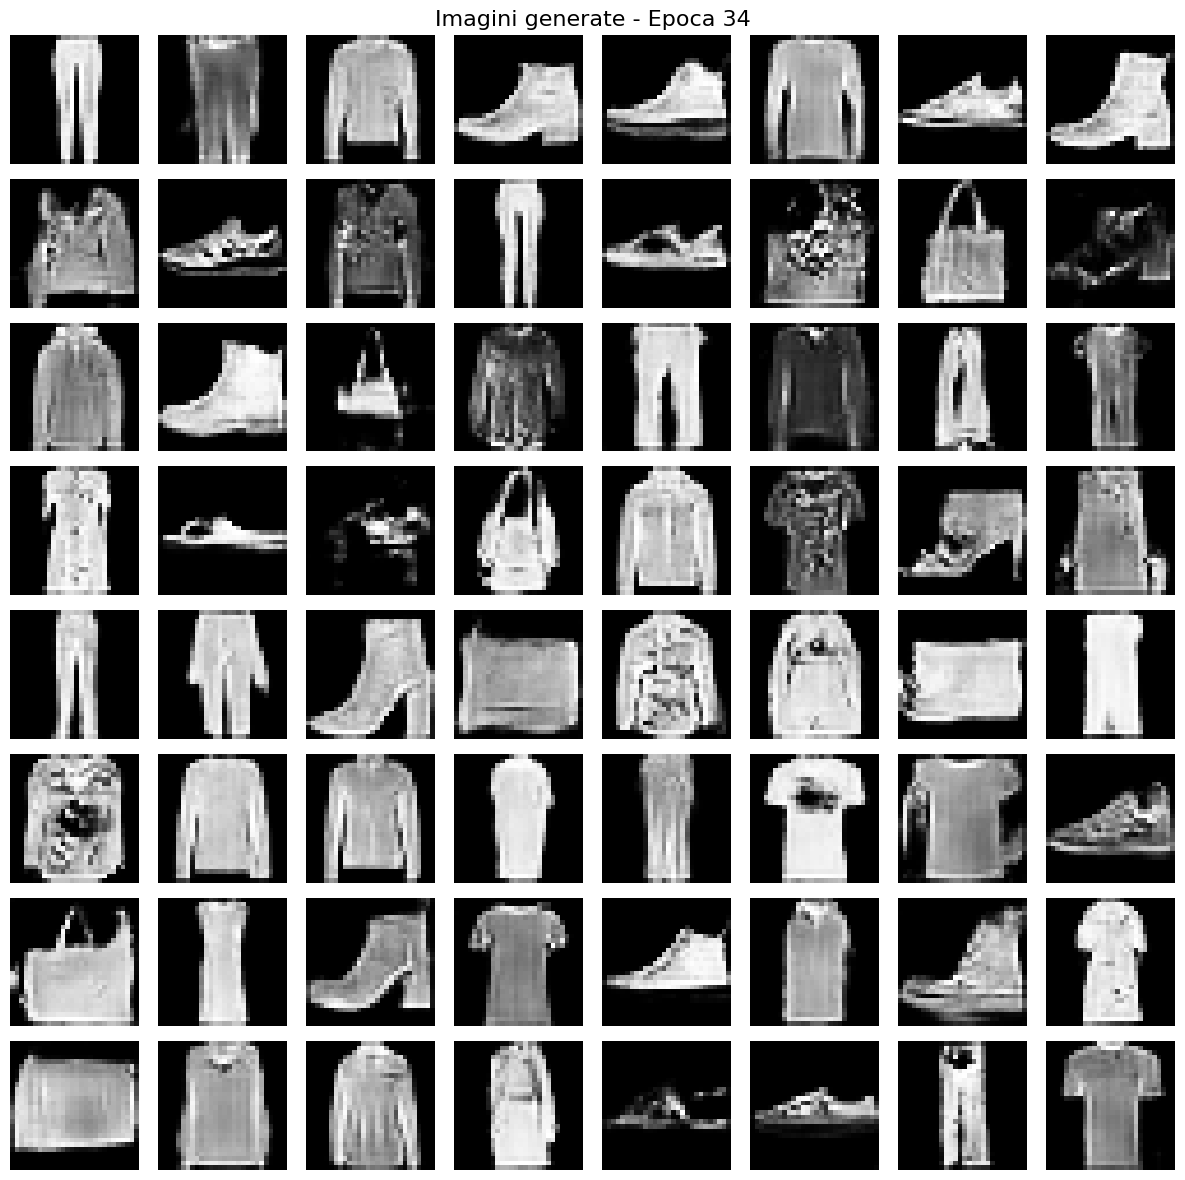

Epoch [35/50] Batch [0/469] Loss_D: 1.2019 (Real: 0.5652, Fake: 0.6366) Loss_G: 0.9589
Epoch [35/50] Batch [100/469] Loss_D: 1.1704 (Real: 0.5166, Fake: 0.6538) Loss_G: 0.9591
Epoch [35/50] Batch [200/469] Loss_D: 1.1763 (Real: 0.5760, Fake: 0.6003) Loss_G: 1.0157
Epoch [35/50] Batch [300/469] Loss_D: 1.0987 (Real: 0.5700, Fake: 0.5287) Loss_G: 1.0580
Epoch [35/50] Batch [400/469] Loss_D: 1.1774 (Real: 0.5990, Fake: 0.5784) Loss_G: 1.0437
Epoch [35/50] - Loss_G: 1.0251, Loss_D: 1.2022
Epoch [36/50] Batch [0/469] Loss_D: 1.3694 (Real: 0.6864, Fake: 0.6830) Loss_G: 1.0238
Epoch [36/50] Batch [100/469] Loss_D: 1.1573 (Real: 0.5858, Fake: 0.5714) Loss_G: 1.0145
Epoch [36/50] Batch [200/469] Loss_D: 1.1783 (Real: 0.6122, Fake: 0.5661) Loss_G: 0.9764
Epoch [36/50] Batch [300/469] Loss_D: 1.1191 (Real: 0.6016, Fake: 0.5175) Loss_G: 1.1327
Epoch [36/50] Batch [400/469] Loss_D: 1.3104 (Real: 0.6211, Fake: 0.6893) Loss_G: 1.0532
Epoch [36/50] - Loss_G: 1.0186, Loss_D: 1.2027
Epoch [37/50] Batch 

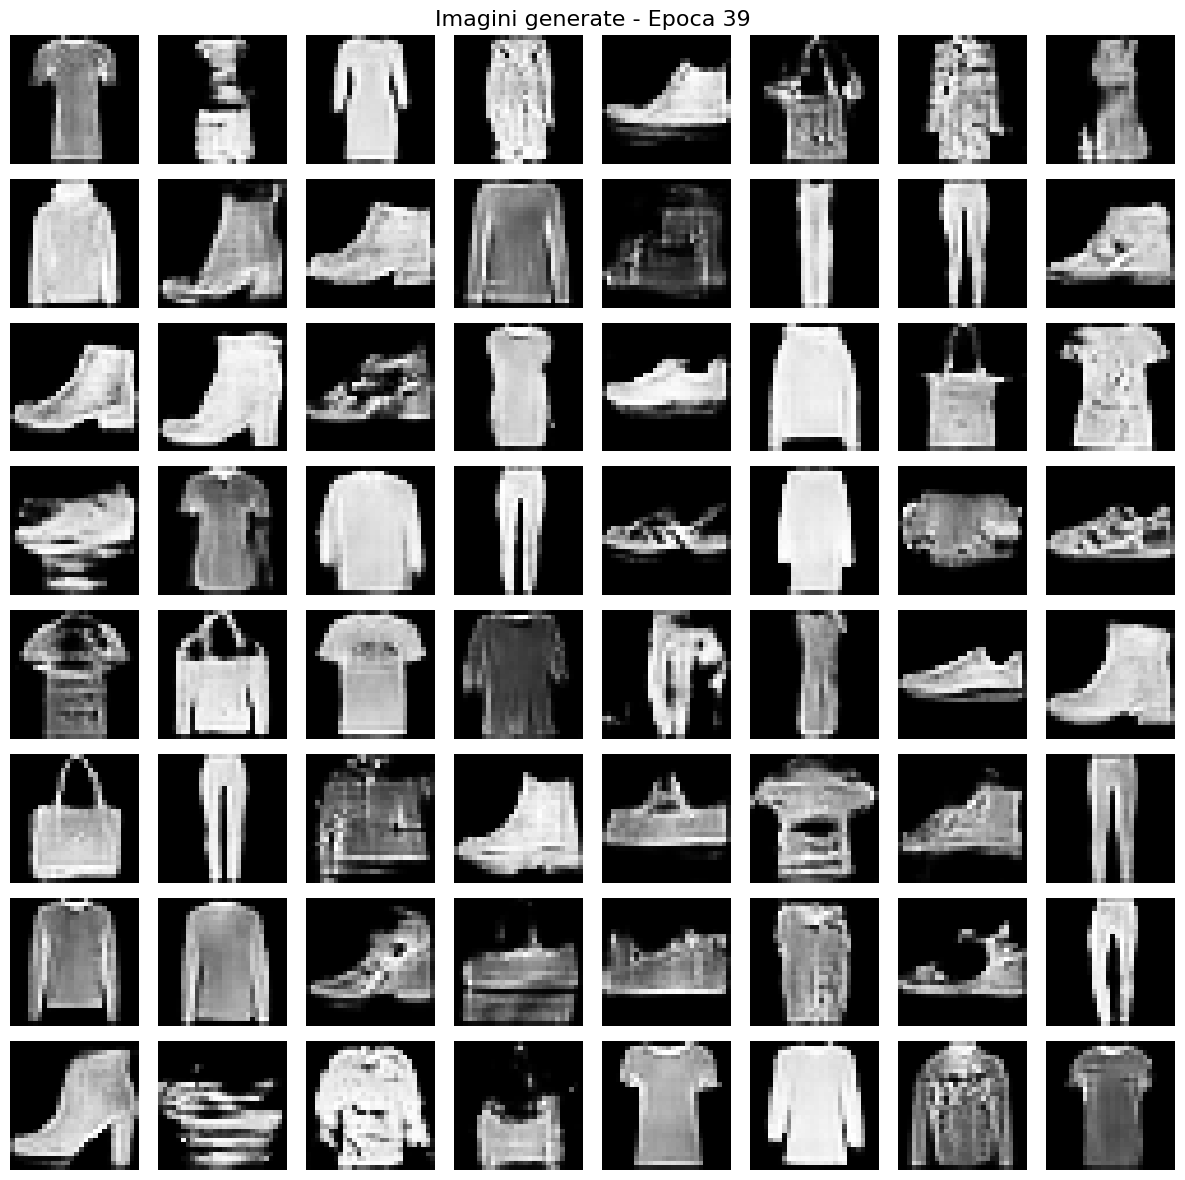

Epoch [40/50] Batch [0/469] Loss_D: 1.1467 (Real: 0.5614, Fake: 0.5853) Loss_G: 0.9698
Epoch [40/50] Batch [100/469] Loss_D: 1.2051 (Real: 0.5846, Fake: 0.6205) Loss_G: 1.0015
Epoch [40/50] Batch [200/469] Loss_D: 1.2531 (Real: 0.5858, Fake: 0.6673) Loss_G: 1.0772
Epoch [40/50] Batch [300/469] Loss_D: 1.1035 (Real: 0.5423, Fake: 0.5612) Loss_G: 0.9712
Epoch [40/50] Batch [400/469] Loss_D: 1.1000 (Real: 0.5889, Fake: 0.5110) Loss_G: 0.9665
Epoch [40/50] - Loss_G: 1.0127, Loss_D: 1.2021
Epoch [41/50] Batch [0/469] Loss_D: 1.1991 (Real: 0.5892, Fake: 0.6099) Loss_G: 1.0107
Epoch [41/50] Batch [100/469] Loss_D: 1.1829 (Real: 0.6262, Fake: 0.5567) Loss_G: 0.9574
Epoch [41/50] Batch [200/469] Loss_D: 1.2696 (Real: 0.6381, Fake: 0.6314) Loss_G: 0.9998
Epoch [41/50] Batch [300/469] Loss_D: 1.2441 (Real: 0.6350, Fake: 0.6091) Loss_G: 1.0174
Epoch [41/50] Batch [400/469] Loss_D: 1.1221 (Real: 0.5768, Fake: 0.5453) Loss_G: 1.1293
Epoch [41/50] - Loss_G: 1.0099, Loss_D: 1.2097
Epoch [42/50] Batch 

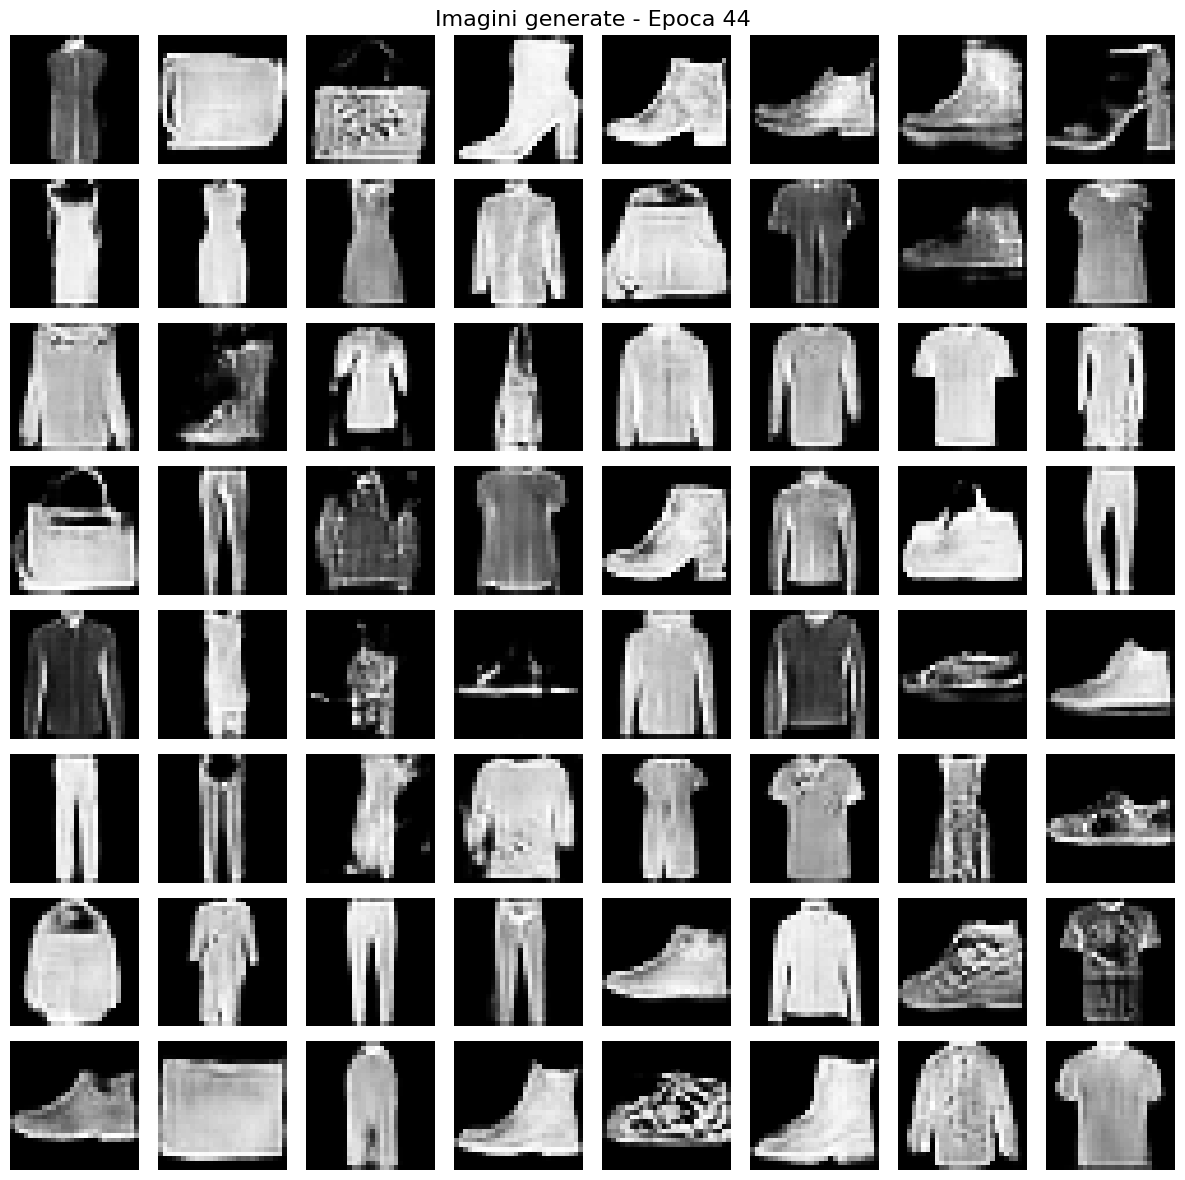

Epoch [45/50] Batch [0/469] Loss_D: 1.2386 (Real: 0.6723, Fake: 0.5662) Loss_G: 1.0374
Epoch [45/50] Batch [100/469] Loss_D: 1.2461 (Real: 0.6234, Fake: 0.6227) Loss_G: 1.0776
Epoch [45/50] Batch [200/469] Loss_D: 1.1286 (Real: 0.6125, Fake: 0.5161) Loss_G: 1.1651
Epoch [45/50] Batch [300/469] Loss_D: 1.2249 (Real: 0.5862, Fake: 0.6387) Loss_G: 1.0499
Epoch [45/50] Batch [400/469] Loss_D: 1.2212 (Real: 0.6717, Fake: 0.5495) Loss_G: 0.9813
Epoch [45/50] - Loss_G: 1.0070, Loss_D: 1.2094
Epoch [46/50] Batch [0/469] Loss_D: 1.1928 (Real: 0.6078, Fake: 0.5850) Loss_G: 0.9565
Epoch [46/50] Batch [100/469] Loss_D: 1.2465 (Real: 0.6130, Fake: 0.6335) Loss_G: 1.0360
Epoch [46/50] Batch [200/469] Loss_D: 1.2519 (Real: 0.6617, Fake: 0.5903) Loss_G: 0.9812
Epoch [46/50] Batch [300/469] Loss_D: 1.1923 (Real: 0.6215, Fake: 0.5708) Loss_G: 0.9971
Epoch [46/50] Batch [400/469] Loss_D: 1.2349 (Real: 0.5597, Fake: 0.6752) Loss_G: 1.0625
Epoch [46/50] - Loss_G: 1.0080, Loss_D: 1.2138
Epoch [47/50] Batch 

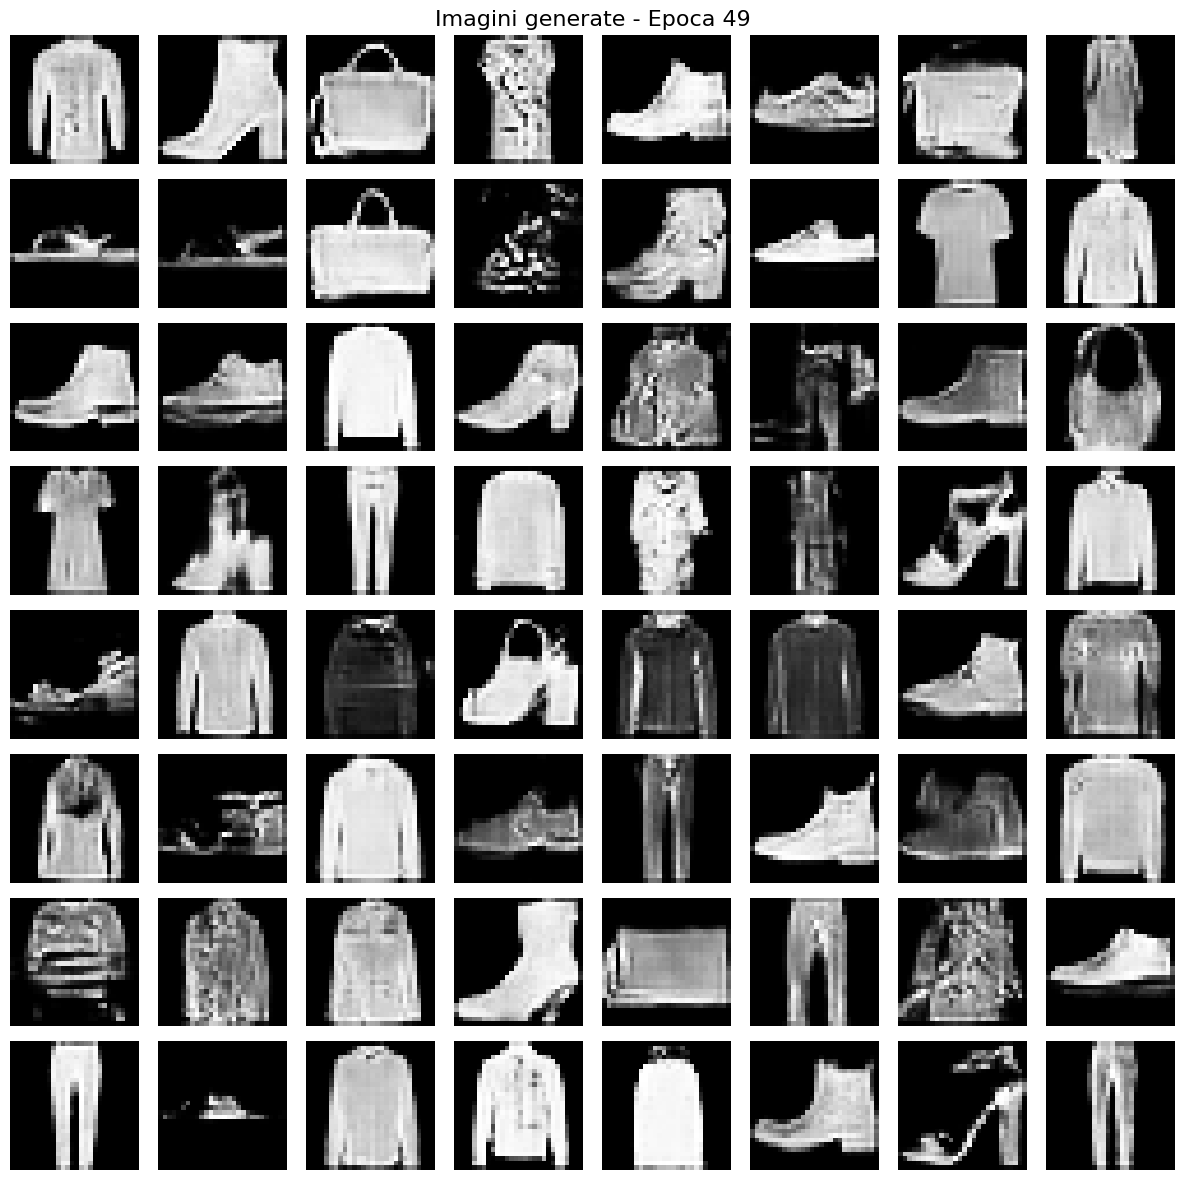

Antrenare completă!


In [10]:
# Parametri antrenare
NUM_EPOCHS = 50
PRINT_EVERY = 100  # Afișează progresul la fiecare N batch-uri
SAVE_EVERY = 5     # Salvează imagini la fiecare N epoci

# Listă pentru stocarea pierderilor
losses_G = []
losses_D = []

print("Început antrenare...")
print(f"Număr epoci: {NUM_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Lungime dataset: {len(train_dataset)}")
print("-" * 50)

for epoch in range(NUM_EPOCHS):
    epoch_loss_G = 0.0
    epoch_loss_D = 0.0
    
    for batch_idx, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # ============================================
        # ANTrenare DISCRIMINATOR
        # ============================================
        discriminator.zero_grad()
        
        # Forward pass pe imagini reale
        # Etichete: toate sunt 1 (reale)
        label_real = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output_real = discriminator(real_images).squeeze()
        loss_D_real = criterion(output_real, label_real)
        
        # Forward pass pe imagini false
        # Generează vectori latenți aleatori
        noise = torch.randn(batch_size, LATENT_DIM, device=device)
        fake_images = generator(noise)
        
        # Etichete: toate sunt 0 (false)
        label_fake = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        output_fake = discriminator(fake_images.detach()).squeeze()
        loss_D_fake = criterion(output_fake, label_fake)
        
        # Loss total pentru discriminator
        # Pierderea este suma dintre pierderea pe imagini reale și cea pe imagini false
        loss_D = loss_D_real + loss_D_fake
        
        # Backward pass și update
        loss_D.backward()
        optimizer_D.step()
        
        # ============================================
        # ANTrenare GENERATOR
        # ============================================
        generator.zero_grad()
        
        # Generează imagini false
        # Notă: folosim același noise sau generăm unul nou
        noise = torch.randn(batch_size, LATENT_DIM, device=device)
        fake_images = generator(noise)
        
        # Forward pass prin discriminator
        # Etichete: toate sunt 1 (încercăm să păcălim discriminatorul)
        # Generatorul vrea ca discriminatorul să creadă că imaginile sunt reale
        label_real_for_G = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(fake_images).squeeze()
        
        # Loss pentru generator
        # Minimizăm pierderea când discriminatorul crede că imaginile sunt reale
        loss_G = criterion(output, label_real_for_G)
        
        # Backward pass și update
        loss_G.backward()
        optimizer_G.step()
        
        # Acumulare pierderi pentru epocă
        epoch_loss_G += loss_G.item()
        epoch_loss_D += loss_D.item()
        
        # Afișare progres
        if batch_idx % PRINT_EVERY == 0:
            print(f'Epoch [{epoch}/{NUM_EPOCHS}] Batch [{batch_idx}/{len(train_loader)}] '
                  f'Loss_D: {loss_D.item():.4f} (Real: {loss_D_real.item():.4f}, Fake: {loss_D_fake.item():.4f}) '
                  f'Loss_G: {loss_G.item():.4f}')
        
        # Monitorizare gradienti (la fiecare 500 batch-uri)
        if batch_idx % 500 == 0:
            grad_stats_G = compute_gradient_norms(generator)
            grad_stats_D = compute_gradient_norms(discriminator)
            
            gradient_history['G']['norms'].append(grad_stats_G['mean_norm'])
            gradient_history['G']['epochs'].append(epoch + batch_idx / len(train_loader))
            gradient_history['D']['norms'].append(grad_stats_D['mean_norm'])
            gradient_history['D']['epochs'].append(epoch + batch_idx / len(train_loader))
            
            # Verificare mode collapse
            with torch.no_grad():
                test_noise = torch.randn(64, LATENT_DIM, device=device)
                test_fake = generator(test_noise)
                collapse_stats = check_mode_collapse(test_fake)
                mode_collapse_history.append({
                    'epoch': epoch + batch_idx / len(train_loader),
                    'mean_std': collapse_stats['mean_std'],
                    'is_collapsed': collapse_stats['is_collapsed']
                })
    
    # Pierderi medii pe epocă
    avg_loss_G = epoch_loss_G / len(train_loader)
    avg_loss_D = epoch_loss_D / len(train_loader)
    losses_G.append(avg_loss_G)
    losses_D.append(avg_loss_D)
    
    print(f'Epoch [{epoch}/{NUM_EPOCHS}] - Loss_G: {avg_loss_G:.4f}, Loss_D: {avg_loss_D:.4f}')
    
    # Salvare imagini generate
    if (epoch + 1) % SAVE_EVERY == 0 or epoch == 0:
        save_generated_images(generator, epoch, LATENT_DIM, num_images=64)

print("Antrenare completă!")

## 8. Vizualizare Rezultate și Analiză

### 8.1. Graficul Pierderilor

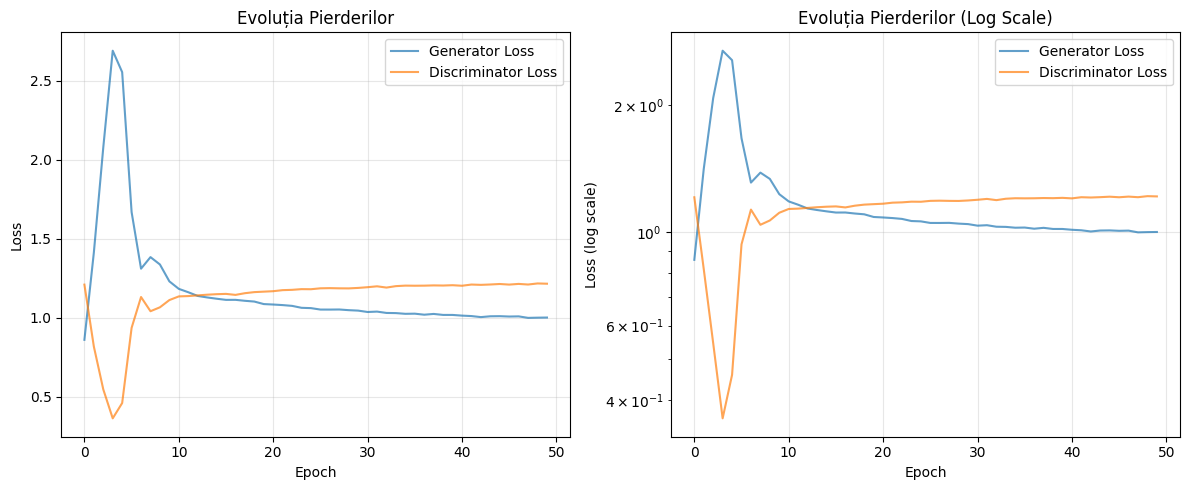

Analiză echilibru antrenare:
Loss Generator mediu: 1.1739
Loss Discriminator mediu: 1.1216
Raport Loss_D/Loss_G: 0.9554

Interpretare:
- Raport aproape de 1: echilibru bun
- Raport >> 1: discriminator prea puternic
- Raport << 1: generator prea puternic


In [11]:
# Plot pierderi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_G, label='Generator Loss', alpha=0.7)
plt.plot(losses_D, label='Discriminator Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evoluția Pierderilor')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(losses_G, label='Generator Loss', alpha=0.7)
plt.plot(losses_D, label='Discriminator Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Evoluția Pierderilor (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analiză echilibru
print("Analiză echilibru antrenare:")
print(f"Loss Generator mediu: {np.mean(losses_G):.4f}")
print(f"Loss Discriminator mediu: {np.mean(losses_D):.4f}")
print(f"Raport Loss_D/Loss_G: {np.mean(losses_D) / np.mean(losses_G):.4f}")
print("\nInterpretare:")
print("- Raport aproape de 1: echilibru bun")
print("- Raport >> 1: discriminator prea puternic")
print("- Raport << 1: generator prea puternic")

### 8.2. Analiza Gradientilor (Detectare Vanishing Gradients)

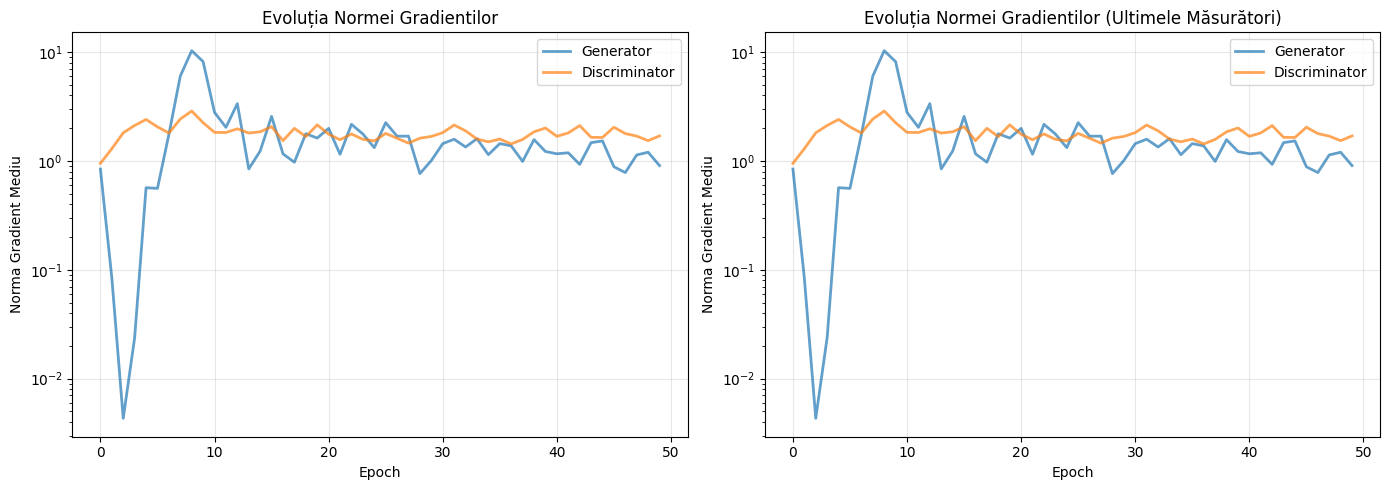

Statistici Gradienti:
Generator - Normă medie: 1.749653
Generator - Normă minimă: 0.004317
Discriminator - Normă medie: 1.803335
Discriminator - Normă minimă: 0.950932

Interpretare:
- Norme < 1e-5: Posibil vanishing gradient
- Norme > 100: Posibil exploding gradient
- Oscilații mari: Instabilitate în antrenare


In [12]:
# Plot gradienti
if len(gradient_history['G']['norms']) > 0:
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(gradient_history['G']['epochs'], gradient_history['G']['norms'], 
             label='Generator', alpha=0.7, linewidth=2)
    plt.plot(gradient_history['D']['epochs'], gradient_history['D']['norms'], 
             label='Discriminator', alpha=0.7, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Norma Gradient Mediu')
    plt.title('Evoluția Normei Gradientilor')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.subplot(1, 2, 2)
    # Ultimele 50 măsurători pentru vedere detaliată
    if len(gradient_history['G']['norms']) > 50:
        plt.plot(gradient_history['G']['epochs'][-50:], gradient_history['G']['norms'][-50:], 
                 label='Generator', alpha=0.7, linewidth=2)
        plt.plot(gradient_history['D']['epochs'][-50:], gradient_history['D']['norms'][-50:], 
                 label='Discriminator', alpha=0.7, linewidth=2)
    else:
        plt.plot(gradient_history['G']['epochs'], gradient_history['G']['norms'], 
                 label='Generator', alpha=0.7, linewidth=2)
        plt.plot(gradient_history['D']['epochs'], gradient_history['D']['norms'], 
                 label='Discriminator', alpha=0.7, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Norma Gradient Mediu')
    plt.title('Evoluția Normei Gradientilor (Ultimele Măsurători)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Statistici gradienti
    print("Statistici Gradienti:")
    print(f"Generator - Normă medie: {np.mean(gradient_history['G']['norms']):.6f}")
    print(f"Generator - Normă minimă: {np.min(gradient_history['G']['norms']):.6f}")
    print(f"Discriminator - Normă medie: {np.mean(gradient_history['D']['norms']):.6f}")
    print(f"Discriminator - Normă minimă: {np.min(gradient_history['D']['norms']):.6f}")
    print("\nInterpretare:")
    print("- Norme < 1e-5: Posibil vanishing gradient")
    print("- Norme > 100: Posibil exploding gradient")
    print("- Oscilații mari: Instabilitate în antrenare")
else:
    print("Nu există date despre gradienti. Asigură-te că monitorizarea este activată în training loop.")

### 8.3. Detectare Mode Collapse

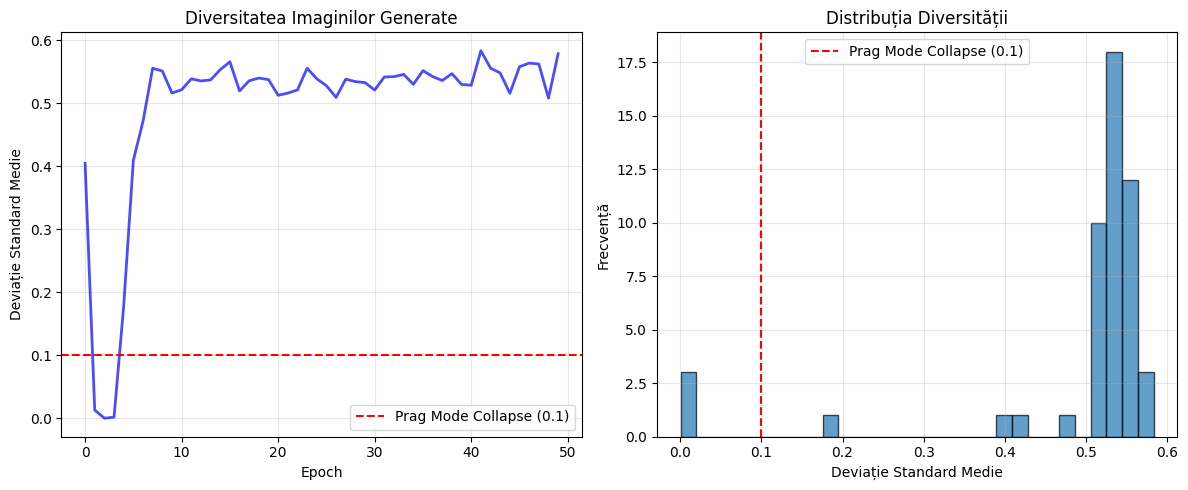

Analiză Mode Collapse:
Deviație standard medie: 0.4934
Deviație standard minimă: 0.0004
Număr măsurători cu mode collapse: 3/50
Procent mode collapse: 6.00%

Interpretare:
- Deviație standard mică (< 0.1): Posibil mode collapse
- Deviație standard mare (> 0.2): Diversitate bună

Generare imagini finale pentru verificare vizuală...


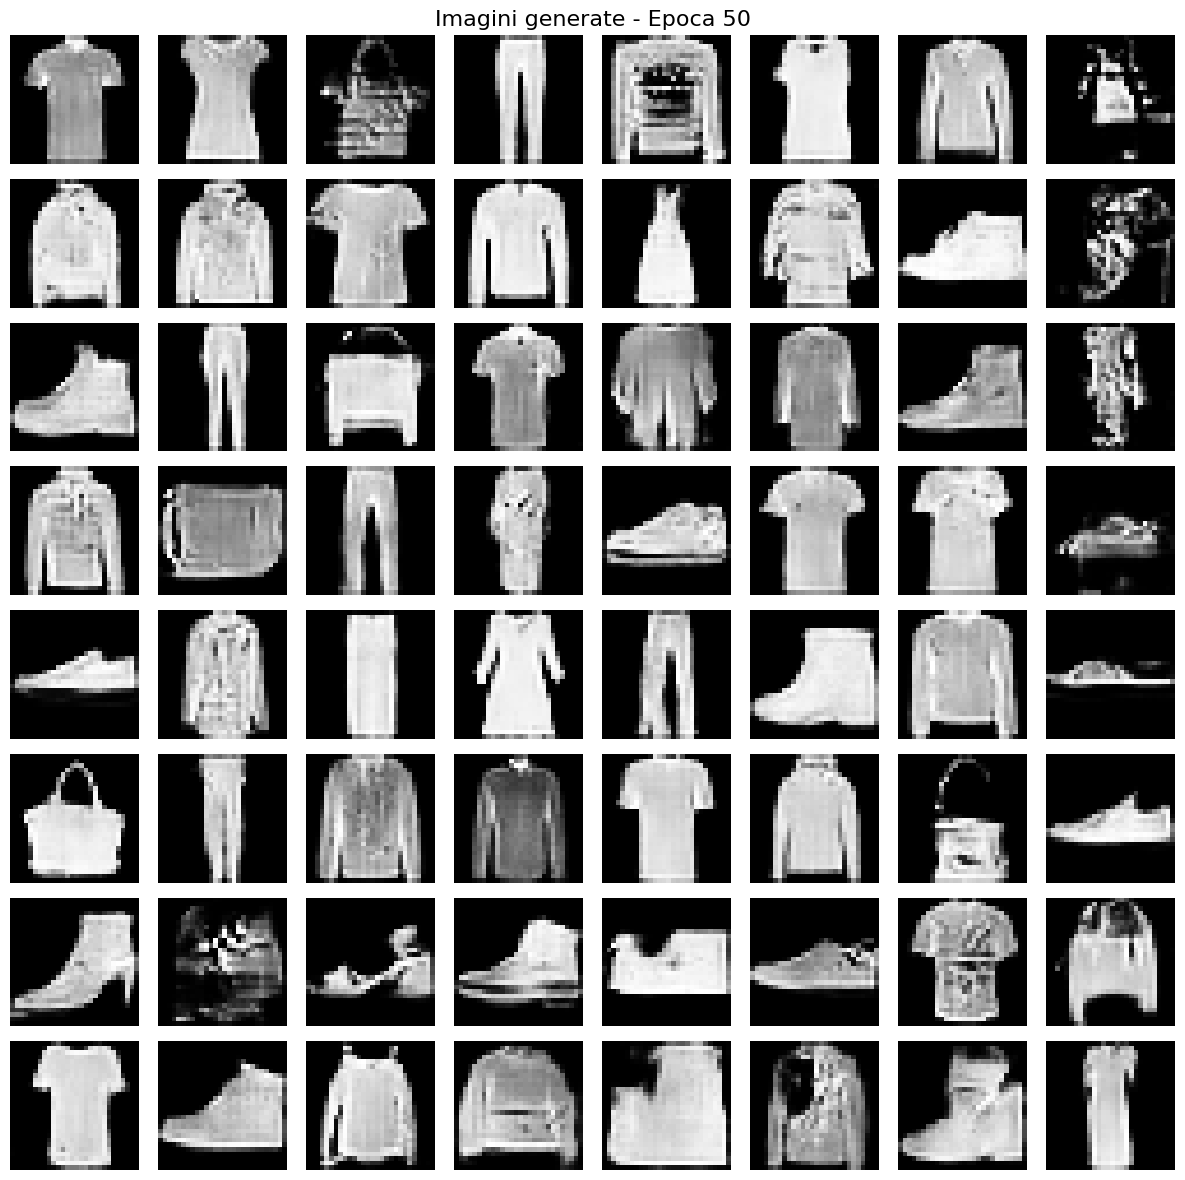

In [13]:
# Analiză mode collapse
if len(mode_collapse_history) > 0:
    epochs_collapse = [h['epoch'] for h in mode_collapse_history]
    stds_collapse = [h['mean_std'] for h in mode_collapse_history]
    collapsed_flags = [h['is_collapsed'] for h in mode_collapse_history]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_collapse, stds_collapse, alpha=0.7, linewidth=2, color='blue')
    plt.axhline(y=0.1, color='r', linestyle='--', label='Prag Mode Collapse (0.1)')
    plt.xlabel('Epoch')
    plt.ylabel('Deviație Standard Medie')
    plt.title('Diversitatea Imaginilor Generate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Histogramă deviații standard
    plt.hist(stds_collapse, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(x=0.1, color='r', linestyle='--', label='Prag Mode Collapse (0.1)')
    plt.xlabel('Deviație Standard Medie')
    plt.ylabel('Frecvență')
    plt.title('Distribuția Diversității')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistici
    num_collapsed = sum(collapsed_flags)
    print("Analiză Mode Collapse:")
    print(f"Deviație standard medie: {np.mean(stds_collapse):.4f}")
    print(f"Deviație standard minimă: {np.min(stds_collapse):.4f}")
    print(f"Număr măsurători cu mode collapse: {num_collapsed}/{len(collapsed_flags)}")
    print(f"Procent mode collapse: {100 * num_collapsed / len(collapsed_flags):.2f}%")
    print("\nInterpretare:")
    print("- Deviație standard mică (< 0.1): Posibil mode collapse")
    print("- Deviație standard mare (> 0.2): Diversitate bună")
    
    # Generare imagini finale pentru verificare vizuală
    print("\nGenerare imagini finale pentru verificare vizuală...")
    generator.eval()
    with torch.no_grad():
        test_noise = torch.randn(64, LATENT_DIM, device=device)
        final_images = generator(test_noise)
    
    save_generated_images(generator, NUM_EPOCHS, LATENT_DIM, num_images=64)
    generator.train()
else:
    print("Nu există date despre mode collapse. Asigură-te că monitorizarea este activată în training loop.")

## 9. Salvare Modele

Salvăm modelele antrenate pentru utilizare ulterioară.

In [14]:
# Creare director pentru modele
os.makedirs('./models', exist_ok=True)

# Salvare modele
torch.save(generator.state_dict(), './models/generator_final.pth')
torch.save(discriminator.state_dict(), './models/discriminator_final.pth')

print("Modele salvate în ./models/")
print("- generator_final.pth")
print("- discriminator_final.pth")

Modele salvate în ./models/
- generator_final.pth
- discriminator_final.pth


## 10. Concluzii și Observații

### Rezultate Obținute
- Modelul DCGAN a fost antrenat cu succes pe Fashion-MNIST
- Generatorul învață să producă imagini de îmbrăcăminte diverse
- Discriminatorul devine capabil să distingă între imagini reale și false

### Instabilități Identificate
- **Vanishing Gradients**: Monitorizat prin analiza normelor gradientilor
- **Mode Collapse**: Detectat prin analiza variabilității pixelilor
- **Echilibru Antrenare**: Evaluat prin raportul pierderilor Generator/Discriminator

### Îmbunătățiri Posibile
1. **Learning Rate Scheduling**: Reducere progresivă a learning rate-ului
2. **Label Smoothing**: Utilizare etichete "soft" (0.9 în loc de 1.0) pentru stabilitate
3. **Spectral Normalization**: Normalizare spectrală pentru stabilitate suplimentară
4. **Progressive Growing**: Creștere progresivă a rezoluției (de la 14x14 la 28x28)

### Referințe
- **Radford, A., Metz, L., & Chintala, S. (2015).** Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. *arXiv preprint arXiv:1511.06434*.
- **Goodfellow, I., et al. (2014).** Generative Adversarial Nets. *Advances in neural information processing systems, 27*.